# **Model Training, Tuning and Deployment**

In this notebook, an SVM regression model is trained to predict CO2 emissions. When successfully built, the model can provide predictions for CO2 emissions in different scenarios, which can contribute to better CO2 emissions monitoring, urban planning and emissions control.

Model Assessment Metrics: mean squared error, R squared score

## **Table of Content**
1. Import Libraries and Load the Dataset
   - Import necessary libraries and load the dataset into the environment
2. Examine the Target Variable
   - Examine if the dataset is biased, skewed, or imbalanced
   - Handle issues
3. Data Transformation
    - Split the dataset before standardisation
    - Scaling features
4. Build the Baseline Model
    - Build the baseline model with linear kernel
    - Evaluation, if issues, then
    - Handle isseus (outliers)
5. Explore better Models
    - 5.1 Build the model with rbf kernel
        - Hyperparatemter tuning and select the best model
    - 5.2 Build the model with poly kernel
        - Hyperparameter tuning and select the best model
6. Validation and Testing
    - Validation of each model with validation set
    - Model selection
7. Save model ready for deployment
    - Save best model

<div style="border-top: 7px solid #800080; animation: sparkling 2s linear infinite;"></div>

<style>
@keyframes sparkling {
  0% { background-position: 0 0; }
  100% { background-position: 100% 0; }
}
</style>

**1. Import Libraries and Load the Dataset**

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn import svm
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
import warnings

In [6]:
warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
df = pd.read_csv('Cleaned CO2 Summary.csv')

<div style="border-top: 7px solid #800080; animation: sparkling 2s linear infinite;"></div>

<style>
@keyframes sparkling {
  0% { background-position: 0 0; }
  100% { background-position: 100% 0; }
}
</style>

**2. Examine the Target Variable**
- Examine if the dataset is biased, skewed, or imbalanced
- Handle issues

Examine

Text(0.5, 1.0, 'Total Emission Distribution')

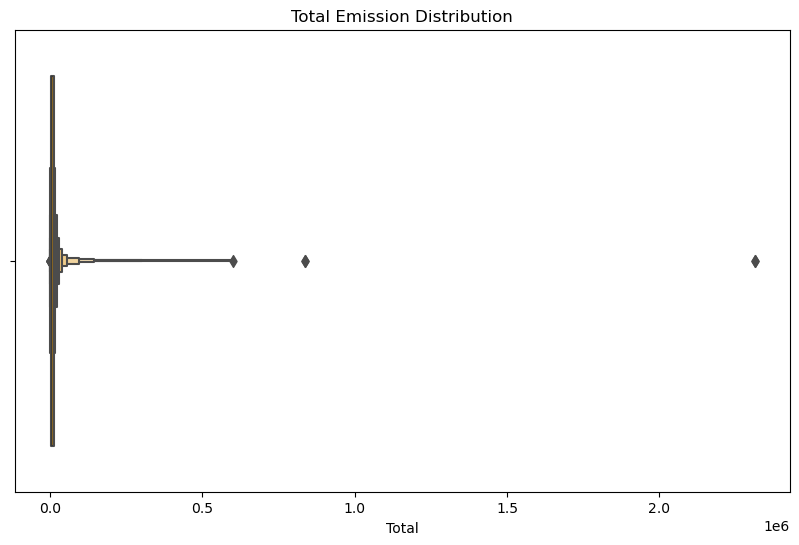

In [7]:
# Make a boxplot for the target
plt.figure(figsize=(10, 6))
sns.boxenplot(x=df['Total'], color ='orange')
plt.title('Total Emission Distribution')

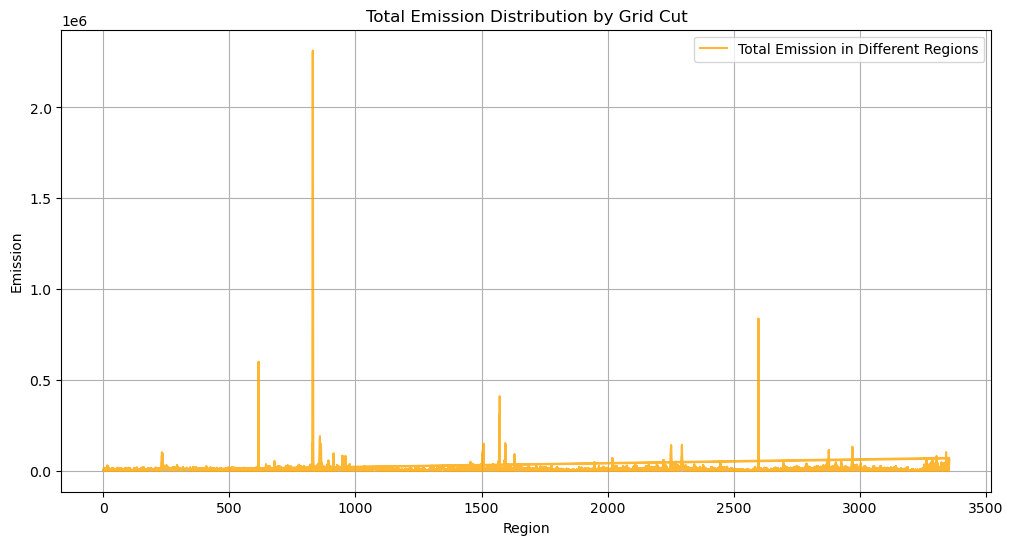

In [7]:
# Further examine extreme pollution
plot_data = df.set_index('GRID_ExactCut_ID')

plt.figure(figsize=(12, 6))
plt.plot(plot_data.index, plot_data['Total'], label='Total Emission in Different Regions', color = 'orange', alpha=0.8)
plt.xlabel('Region')
plt.ylabel('Emission')
plt.title('Total Emission Distribution by Grid Cut')
plt.legend()
plt.grid(True)
plt.show()

In [8]:
# Basic Statistics of the target
df['Total'].describe()

count    1.006500e+04
mean     9.685670e+03
std      3.804064e+04
min      5.620224e-02
25%      1.766579e+03
50%      6.328637e+03
75%      1.241446e+04
max      2.312328e+06
Name: Total, dtype: float64

Handle Target Variable - Right Skewed

In [9]:
# Log transformation the target
df['Total_log'] = np.log(df['Total'])

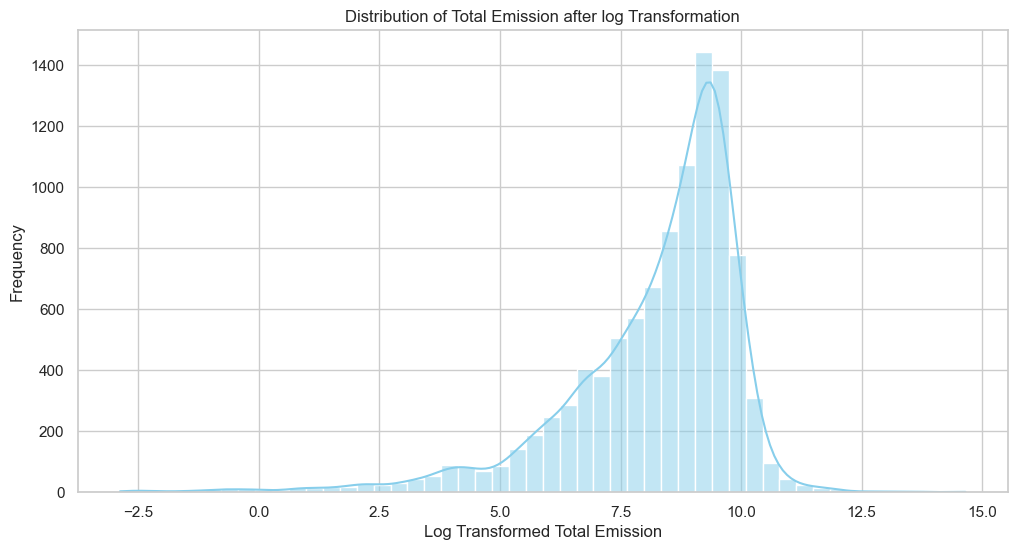

In [10]:
# Check the improvement of the distribution after the log transformation.
# Plot the log traget
sns.set(style='whitegrid')
plt.figure(figsize=(12, 6))
sns.histplot(df['Total_log'], bins=50, color='skyblue', kde=True)
plt.xlabel('Log Transformed Total Emission')
plt.ylabel('Frequency')
plt.title('Distribution of Total Emission after log Transformation')
plt.grid(True)
plt.show()

In [11]:
# Remove original Target variable which is skewed
df = df.drop('Total', axis=1)

<div style="border-top: 7px solid #800080; animation: sparkling 2s linear infinite;"></div>

<style>
@keyframes sparkling {
  0% { background-position: 0 0; }
  100% { background-position: 100% 0; }
}
</style>

**3. Data Transformation**
- Split the dataset before standardisation avoid information leakage
- Scaling features

Split Dataset into Train, Test, and Validation Sets

In [12]:
# Separate features and target
X = df.iloc[:, 5:29]
y = df['Total_log']

In [13]:
# Split data into training and temporary (combined testing and validation) sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)

# Split the temporary set into testing and validation sets
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

Scaling Features

In [14]:
# Initialise feature scaler
feature_scaler = StandardScaler()

In [15]:
# Scaling X_train features
X_train_scaled = feature_scaler.fit_transform(X_train)

# Scaling X_test features
X_test_scaled = feature_scaler.transform(X_test)

c:\Users\stoer\anaconda3\envs\Machine_learning\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\stoer\anaconda3\envs\Machine_learning\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\stoer\anaconda3\envs\Machine_learning\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\stoer\anaconda3\envs\Machine_learning\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and wil

In [16]:
# Create PCA instances
pca = PCA(n_components=0.90)

# Fit PCA on the scaled training data
X_train_pca = pca.fit_transform(X_train_scaled)

X_test_pca = pca.transform(X_test_scaled)

<div style="border-top: 7px solid #800080; animation: sparkling 2s linear infinite;"></div>

<style>
@keyframes sparkling {
  0% { background-position: 0 0; }
  100% { background-position: 100% 0; }
}
</style>

**4. Build the Baseline Model**
- Build the baseline model with linear kernel
- Evaluation, if issues, then
- Handle isseus (outliers)

Build Basline Model

In [17]:
# Initialise an empty list to store metrics
metrics = []

# Apply parameter tuning to choose C
for c in range ( 1, 5):
    base_model = svm.SVR(kernel='linear', C=c)
    base_model.fit(X_train_pca, y_train)
    y_pred_base = base_model.predict(X_test_pca)

    mse = mean_squared_error(y_test, y_pred_base)
    r2 = r2_score(y_test, y_pred_base)

    metrics.append(mse)
    metrics.append(r2)

    print(f'For C = {c}, Mean Squard Error: {mse}')
    print(f'For C = {c}, R Squard Score: {r2}')

c:\Users\stoer\anaconda3\envs\Machine_learning\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\stoer\anaconda3\envs\Machine_learning\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


c:\Users\stoer\anaconda3\envs\Machine_learning\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\stoer\anaconda3\envs\Machine_learning\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\stoer\anaconda3\envs\Machine_learning\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\stoer\anaconda3\envs\Machine_learning\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstan

For C = 1, Mean Squard Error: 1.6103352958855472
For C = 1, R Squard Score: 0.4863973218550247


c:\Users\stoer\anaconda3\envs\Machine_learning\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\stoer\anaconda3\envs\Machine_learning\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\stoer\anaconda3\envs\Machine_learning\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\stoer\anaconda3\envs\Machine_learning\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstan

For C = 2, Mean Squard Error: 1.6103727731563824
For C = 2, R Squard Score: 0.48638536879983196


c:\Users\stoer\anaconda3\envs\Machine_learning\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\stoer\anaconda3\envs\Machine_learning\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\stoer\anaconda3\envs\Machine_learning\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\stoer\anaconda3\envs\Machine_learning\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstan

For C = 3, Mean Squard Error: 1.610482318790556
For C = 3, R Squard Score: 0.48635043015616286
For C = 4, Mean Squard Error: 1.6105303373858812
For C = 4, R Squard Score: 0.4863351150356269


c:\Users\stoer\anaconda3\envs\Machine_learning\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\stoer\anaconda3\envs\Machine_learning\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\stoer\anaconda3\envs\Machine_learning\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\stoer\anaconda3\envs\Machine_learning\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstan

In [18]:
# Build the baseline model with C = 1
best_base_model = svm.SVR(kernel='linear', C=1)
best_base_model.fit(X_train_pca, y_train)
y_pred_best_base = best_base_model.predict(X_test_pca)

c:\Users\stoer\anaconda3\envs\Machine_learning\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\stoer\anaconda3\envs\Machine_learning\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


import plotly.express as px
import plotly.graph_objects as go

# Create a DataFrame to hold the true and predicted emissions
result_df = pd.DataFrame({'True Emission': y_test, 'Predicted Emission': y_pred_best_base})

# Create an interactive scatter plot with Plotly
fig = px.scatter(result_df, x='True Emission', y='Predicted Emission', 
                 title='How data points align with the regression line')

# Add a regression line using go.Scatter
fig.add_trace(go.Scatter(x=[y_test.min(), y_test.max()], 
                         y=[y_pred_best_base.min(), y_pred_best_base.max()], 
                         mode='lines', 
                         line=dict(dash='dash'),
                         name='Regression Line'))

fig.update_layout(
    xaxis_title='True Emission',
    yaxis_title='Predicted Emission',
    showlegend=True,  # Hide legend
    height=400,  # Adjust the plot height as needed
    width=800    # Adjust the plot width as needed
)
fig.show()

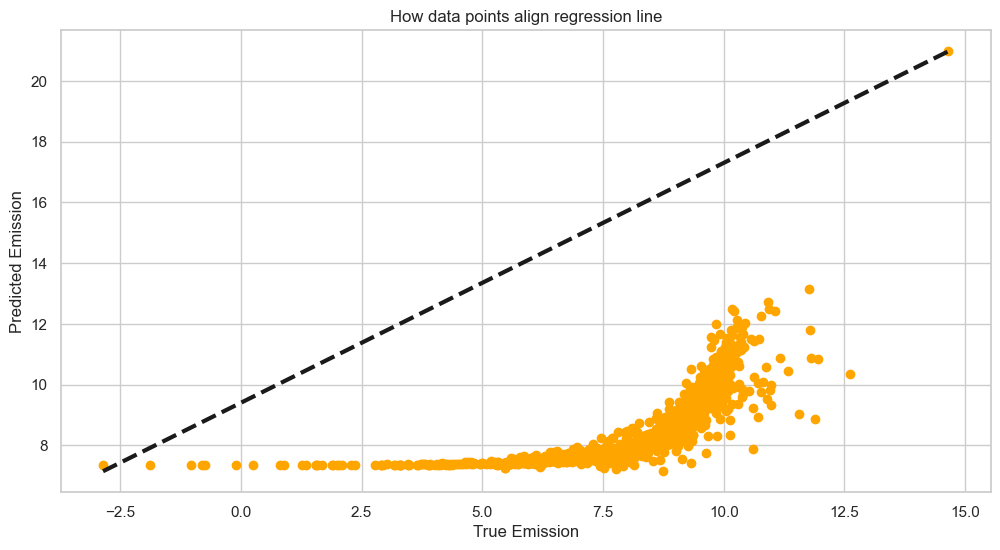

In [19]:
# Visulisation of the result
plt.figure(figsize=(12, 6))

plt.scatter(y_test, y_pred_best_base, color = 'orange')
plt.plot([y_test.min(), y_test.max()], [y_pred_best_base.min(), y_pred_best_base.max()], 'k--', lw = 3)
plt.xlabel('True Emission')
plt.ylabel('Predicted Emission')
plt.title('How data points align regression line')
plt.show()

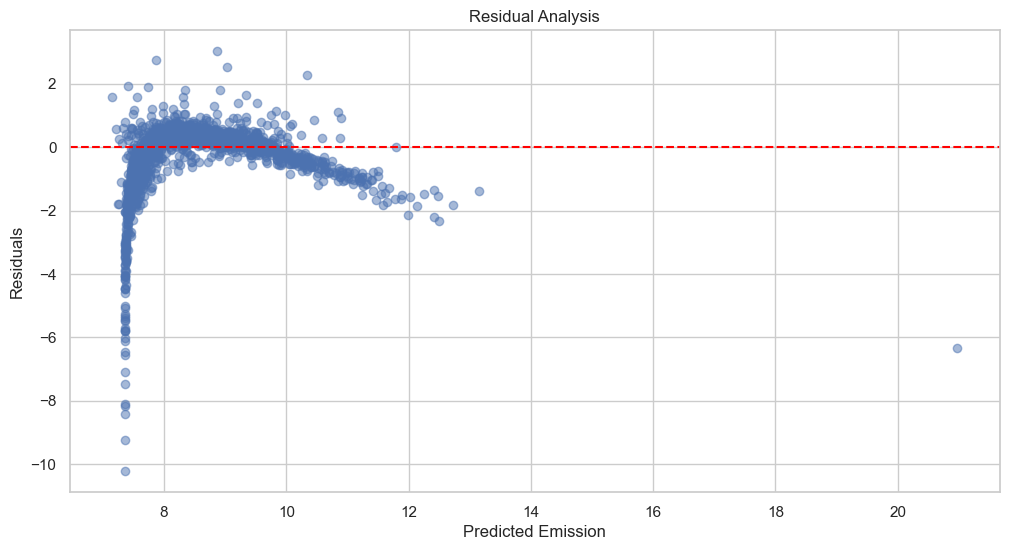

In [21]:
# Analyse residuals
residuals = y_test - y_pred_best_base
plt.figure(figsize=(12, 6))
plt.scatter(y_pred_best_base, residuals, alpha=0.5)
plt.xlabel('Predicted Emission')
plt.ylabel('Residuals')
plt.title('Residual Analysis')
plt.axhline(y=0, color = 'red', linestyle = '--')
plt.show()

Note: From residuals analysis, outliers are identified.

Handle Issues (Outliers)

In [22]:
# Remove outliers applying interquartile range method
Q1 = df['Total_log'].quantile(0.25)
Q3 = df['Total_log'].quantile(0.75)

IQR = Q3-Q1

lower_bound = Q1 - 1.5*IQR
upper_bound = Q3 + 1.5*IQR

df__no_outliers = df[(df['Total_log'] >lower_bound)& (df['Total_log'] < upper_bound)] 

In [23]:
# Re-split dataset into features and target
X = df__no_outliers.iloc[:, 5:29]
y = df__no_outliers['Total_log']

In [24]:
# Split data into training and temporary (combined testing and validation) sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)

# Split the temporary set into testing and validation sets
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [25]:
# Feature scaling again
feature_scaler_clean = StandardScaler()

# Scaling X_train features
X_train_scaled = feature_scaler_clean.fit_transform(X_train)

# Scaling X_test features
X_test_scaled = feature_scaler_clean.transform(X_test)

In [26]:
# Create PCA instances
pca_clean = PCA(n_components=0.90)

# Fit PCA on the scaled training data
X_train_pca = pca_clean.fit_transform(X_train_scaled)

X_test_pca = pca_clean.transform(X_test_scaled)

In [27]:
# Train baseline without outliers
best_base_model_clean = svm.SVR(kernel='linear', C=1)
best_base_model_clean.fit(X_train_pca, y_train)
y_pred_best_base_clean = best_base_model_clean.predict(X_test_pca)

mse = mean_squared_error(y_pred_best_base_clean, y_test)
r2 = r2_score(y_pred_best_base_clean, y_test)

print(f'Mean Squard Error: {mse}')
print(f'R Squard Score: {r2}')

Mean Squard Error: 0.5687254683855778
R Squard Score: 0.43361651611960084


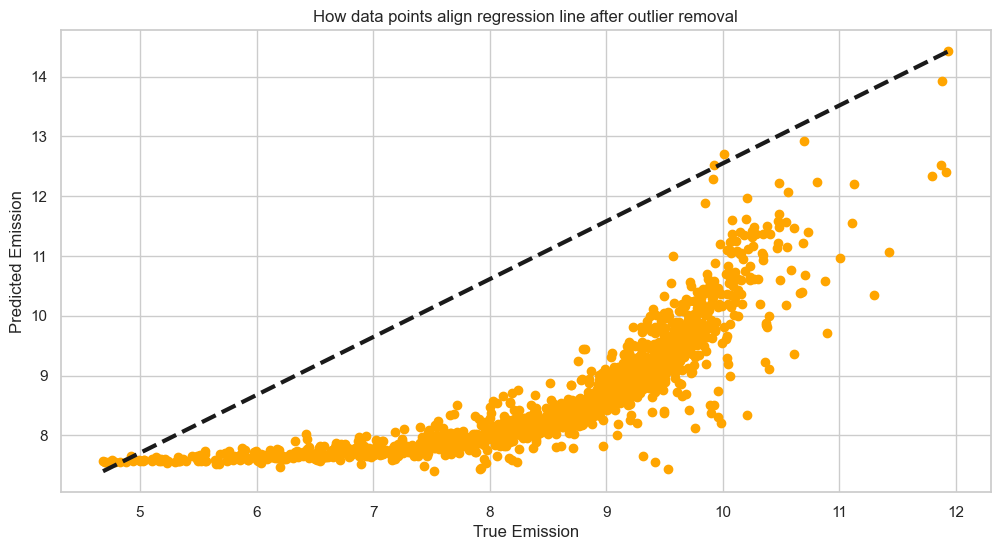

In [28]:
# Visulise the improvement
plt.figure(figsize=(12, 6))

plt.scatter(y_test, y_pred_best_base_clean, color = 'orange')
plt.plot([y_test.min(), y_test.max()], [y_pred_best_base_clean.min(), y_pred_best_base_clean.max()], 'k--', lw = 3)
plt.xlabel('True Emission')
plt.ylabel('Predicted Emission')
plt.title('How data points align regression line after outlier removal')
plt.show()

<div style="border-top: 7px solid #800080; animation: sparkling 2s linear infinite;"></div>

<style>
@keyframes sparkling {
  0% { background-position: 0 0; }
  100% { background-position: 100% 0; }
}
</style>

The visualisation shows that the linear kernel is not the optimal kernel

**5. Explore better Models**
- 5.1 Build the model with rbf kernel
    - Hyperparatemter tuning and select the best model
- 5.2 Build the model with poly kernel
    - Hyperparameter tuning and select the best model

**5.1 Build the model with rbf kernel**

In [29]:
# Grid search for hyperparameter tuning

prameters = {
    'C': [0.01, 0.1, 1, 10],
    'gamma': [0.01, 0.1, 1, 10]
}

# Define the model
rbf_svm = svm.SVR(kernel='rbf')

# Perform grid search
grid_search = GridSearchCV(rbf_svm, prameters, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train_pca, y_train)

# Get the best model
best_rbf_svr = grid_search.best_estimator_

# Make prediction with the best model
y_pred_best_rbf = best_rbf_svr.predict(X_test_pca)

# Evaluations
mse = mean_squared_error(y_test, y_pred_best_rbf)
r2 = r2_score(y_test, y_pred_best_rbf)

print(f'Best C: {best_rbf_svr.C}')
print(f'Best gamma: {best_rbf_svr.gamma}')
print(f'Mean Squared Error: {mse}')
print(f'R Squared: {r2}')

Best C: 10
Best gamma: 0.1
Mean Squared Error: 0.059354071545698994
R Squared: 0.9637357946881333


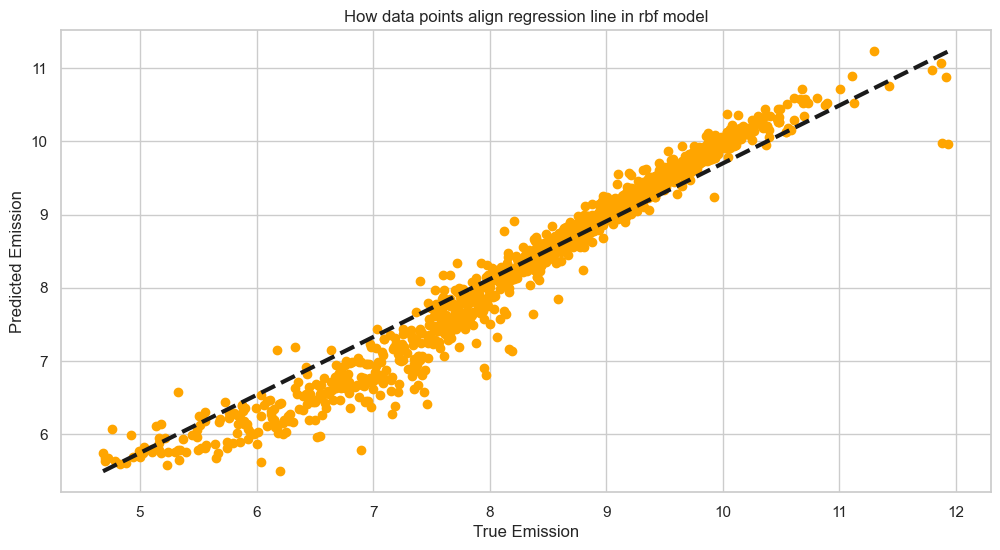

In [30]:
# Visulisation of the outcomes
plt.figure(figsize=(12, 6))

plt.scatter(y_test, y_pred_best_rbf, color = 'orange')
plt.plot([y_test.min(), y_test.max()], [y_pred_best_rbf.min(), y_pred_best_rbf.max()], 'k--', lw = 3)
plt.xlabel('True Emission')
plt.ylabel('Predicted Emission')
plt.title('How data points align regression line in rbf model')
plt.show()

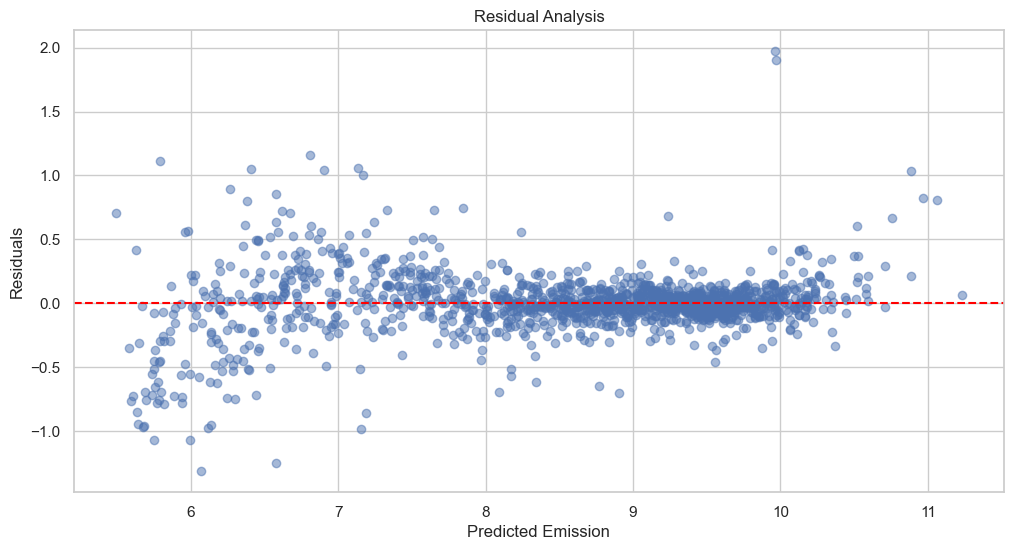

In [31]:
# Analyse residuals
residuals = y_test - y_pred_best_rbf
plt.figure(figsize=(12, 6))
plt.scatter(y_pred_best_rbf, residuals, alpha=0.5)
plt.xlabel('Predicted Emission')
plt.ylabel('Residuals')
plt.title('Residual Analysis')
plt.axhline(y=0, color = 'red', linestyle = '--')
plt.show()


<div style="border-top: 5px solid #E6E6FA; animation: sparkling 2s linear infinite;"></div>

<style>
@keyframes sparkling {
  0% { background-position: 0 0; }
  100% { background-position: 100% 0; }
}
</style>

**5.2 Build the model with poly kernel**

In [32]:
# Grid search for hyperparameter tuning
prameters = {
    'C': [0.01, 0.1, 1, 10],
    'degree': [2, 3]
}

# Define the model
poly_svm = svm.SVR(kernel='poly')

# Perform grid search
grid_search = GridSearchCV(poly_svm, prameters, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train_pca, y_train)

# Get the best model
best_poly_svr = grid_search.best_estimator_

# Make prediction with the best model
y_pred_best_poly = best_poly_svr.predict(X_test_pca)

# Evaluations
mse = mean_squared_error(y_test, y_pred_best_poly)
r2 = r2_score(y_test, y_pred_best_poly)

print(f'Best C: {best_rbf_svr.C}')
print(f'Best degree: {best_rbf_svr.degree}')
print(f'Mean Squared Error: {mse}')
print(f'R Squared: {r2}')

Best C: 10
Best degree: 3
Mean Squared Error: 1.1180022079373473
R Squared: 0.31692198105492686


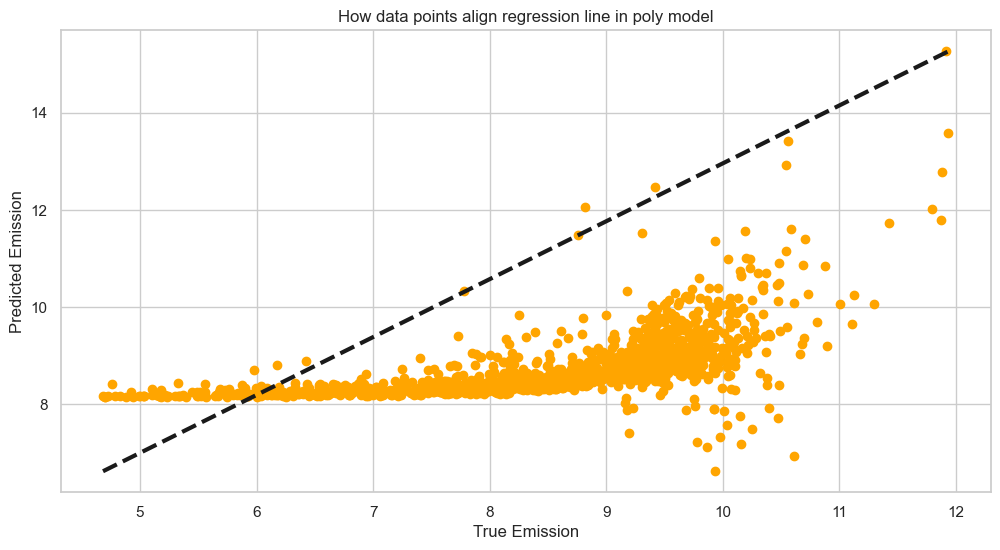

In [33]:
# Visulisation of the outcomes
plt.figure(figsize=(12, 6))

plt.scatter(y_test, y_pred_best_poly, color = 'orange')
plt.plot([y_test.min(), y_test.max()], [y_pred_best_poly.min(), y_pred_best_poly.max()], 'k--', lw = 3)
plt.xlabel('True Emission')
plt.ylabel('Predicted Emission')
plt.title('How data points align regression line in poly model')
plt.show()

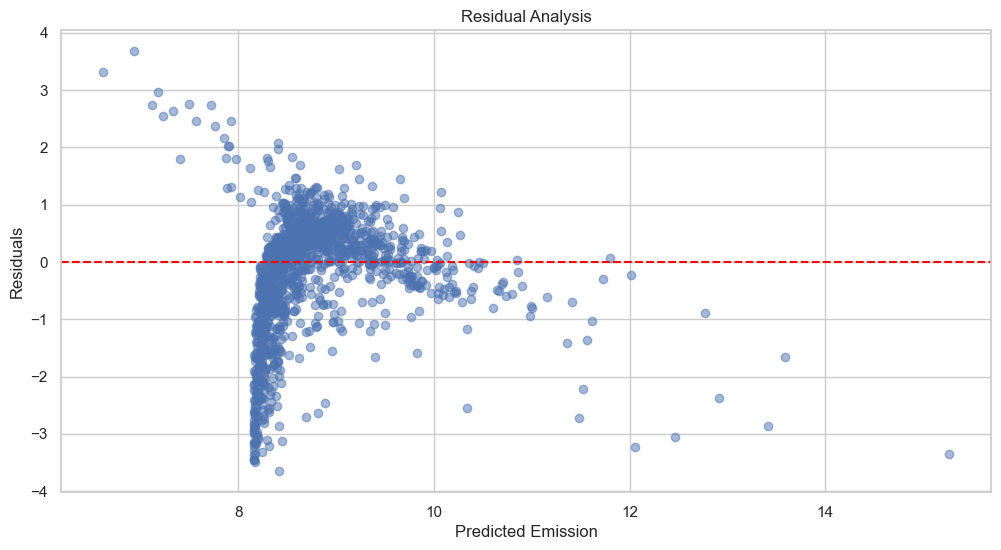

In [34]:
# Analyse residuals
residuals = y_test - y_pred_best_poly
plt.figure(figsize=(12, 6))
plt.scatter(y_pred_best_poly, residuals, alpha=0.5)
plt.xlabel('Predicted Emission')
plt.ylabel('Residuals')
plt.title('Residual Analysis')
plt.axhline(y=0, color = 'red', linestyle = '--')
plt.show()

<div style="border-top: 7px solid #800080; animation: sparkling 2s linear infinite;"></div>

<style>
@keyframes sparkling {
  0% { background-position: 0 0; }
  100% { background-position: 100% 0; }
}
</style>

**6. Validation and Testing**
- Validation of each model with validation set
- Model selection

Validation Models against Validation Set

In [35]:
# Scaling validation features
X_val_scaled = feature_scaler_clean.transform(X_val)
X_val_pca = pca_clean.transform(X_val_scaled)

In [36]:
# Validate baseline model
y_pred_base = best_base_model_clean.predict(X_val_pca)

mse = mean_squared_error(y_pred_base, y_val)
r2 = r2_score(y_pred_base, y_val)

print(f'Mean Squard Error: {mse}')
print(f'R Squard Score: {r2}')

Mean Squard Error: 0.6033962318254431
R Squard Score: 0.32046977012254374


In [37]:
# Validate best rbf model
y_pred_rbf = best_rbf_svr.predict(X_val_pca)

mse = mean_squared_error(y_pred_rbf, y_val)
r2 = r2_score(y_pred_rbf, y_val)

print(f'Mean Squard Error: {mse}')
print(f'R Squard Score: {r2}')

Mean Squard Error: 0.055614501350630625
R Squard Score: 0.9646921033798407


In [38]:
# Validate best poly model
y_pred_poly = best_poly_svr.predict(X_val_pca)

mse = mean_squared_error(y_pred_poly, y_val)
r2 = r2_score(y_pred_poly, y_val)

print(f'Mean Squard Error: {mse}')
print(f'R Squard Score: {r2}')

Mean Squard Error: 1.204838220621065
R Squard Score: -1.8292856193723583


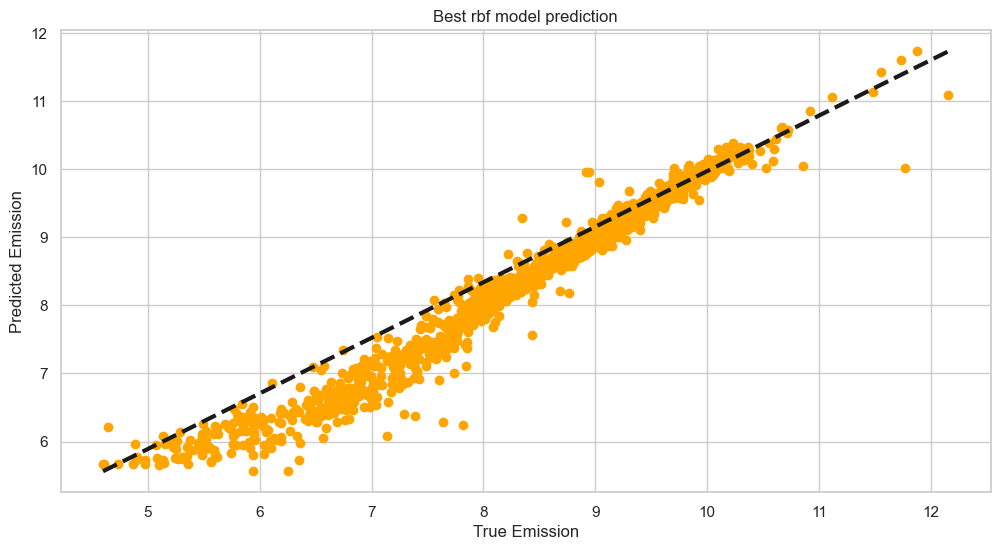

In [39]:
# Visulisation of the best model: rbf
plt.figure(figsize=(12, 6))

plt.scatter(y_val, y_pred_rbf, color = 'orange')
plt.plot([y_val.min(), y_val.max()], [y_pred_rbf.min(), y_pred_rbf.max()], 'k--', lw = 3)
plt.xlabel('True Emission')
plt.ylabel('Predicted Emission')
plt.title('Best rbf model prediction')
plt.show()

Model Selection

Based on the model evaluation metrics, the rbf kernel provides the best model for the data set. The comparison of the predicted and real test values with R2 = 0.97 during traing shows that the model can capture the pattern very well. The residual plot also proves that the model captured the relationships well and the model is quite stable, which can be valided by the validation set in the end with Mean Squard Error: 0.0325494034590185, R Squard Score: 0.9797780509059221

<div style="border-top: 7px solid #800080; animation: sparkling 2s linear infinite;"></div>

<style>
@keyframes sparkling {
  0% { background-position: 0 0; }
  100% { background-position: 100% 0; }
}
</style>

**7. Save model ready for deployment**
- Save best model

In [34]:
import joblib

# Save the trained model to a file
joblib.dump(best_rbf_svr, 'best_rbf_svr.joblib')

['best_rbf_svr.joblib']

Note: Model deployment needs collaboration with data engineers, and DevOps. Model needs to be continuously monitored to avoid concept drift. Retrain model if the model context is changed. 